<a href="https://colab.research.google.com/github/mohIITech/learning_machine_learning/blob/colab/colab_notebooks/neural_networks/u_net_blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [2]:
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

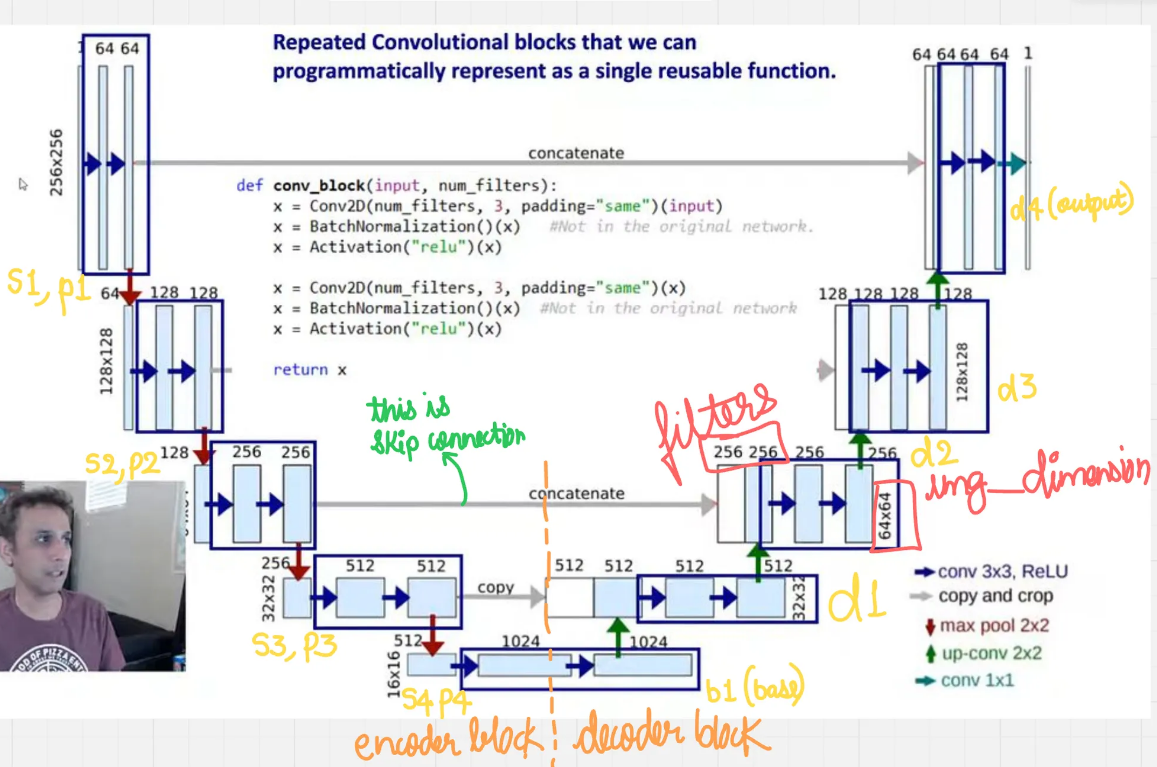

In [3]:
# Encoder block
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p

## Downsampling in the Encoder:
The encoder part of U-Net uses convolutional layers with pooling (like max pooling) to extract features and reduce the spatial size (height and width) of the input image. This process loses some spatial information.
## Upsampling in the Decoder:
The decoder's task is to reconstruct the original image size from the lower resolution feature maps generated by the encoder. To achieve this, the decoder uses upsampling layers, such as transposed convolutions.
## Transposed Convolution:
Transposed convolution is a learnable upsampling method that increases the spatial dimensions (height and width) of the feature maps while potentially reducing the number of channels. It essentially performs a reverse convolution operation, inserting zeros between pixels and then applying a regular convolution

In [4]:
# Decoder block
# skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [5]:
# Build Unet using the blocks
def build_unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024) # This is the bridge

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(1, 1, padding='same', activation='softmax')(d4)

  model = Model(inputs, outputs, name='U-Net')
  return model

In [6]:
# importing dataset

import os
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence
from matplotlib import pyplot as plt

In [7]:
# processing the images

image_dir = '/content/drive/MyDrive/Colab Notebooks/nidar_dataset/Highlighted_softened'
mask_dir = '/content/drive/MyDrive/Colab Notebooks/nidar_dataset/Highlighted_masked'

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

images, masks = [], []
for img_fname, mask_fname in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_fname)
    mask_path = os.path.join(mask_dir, mask_fname)
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128,128)) / 255.0
    mask = cv2.resize(mask, (128,128)) / 255.0
    mask = np.expand_dims(mask, axis=-1)
    images.append(img)
    masks.append(mask)

images = np.array(images)
masks = np.array(masks)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(images, masks, test_size=0.1, random_state=42)


In [15]:
# building model
model = build_unet((128, 128, 3))
model.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:
# training the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=8, validation_data=(X_test, Y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 128, 128, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5740 - loss: 0.0000e+00 - val_accuracy: 0.0831 - val_loss: 0.0000e+00
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.9205 - loss: 0.0000e+00 - val_accuracy: 0.0011 - val_loss: 0.0000e+00
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.9546 - loss: 0.0000e+00 - val_accuracy: 6.1035e-05 - val_loss: 0.0000e+00
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9646 - loss: 0.0000e+00 - val_accuracy: 1.4648e-04 - val_loss: 0.0000e+00
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9667 - loss: 0.0000e+00 - val_accuracy: 0.0060 - val_loss: 0.0000e+00
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9660 - loss: 0.0000e+00 - val_accuracy: 1.4648e-04 - val_loss: 0.0000e+00
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.9711 - loss: 0.0000e+00 - val_accuracy: 0.1338 - val_loss: 0.0000e+00
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


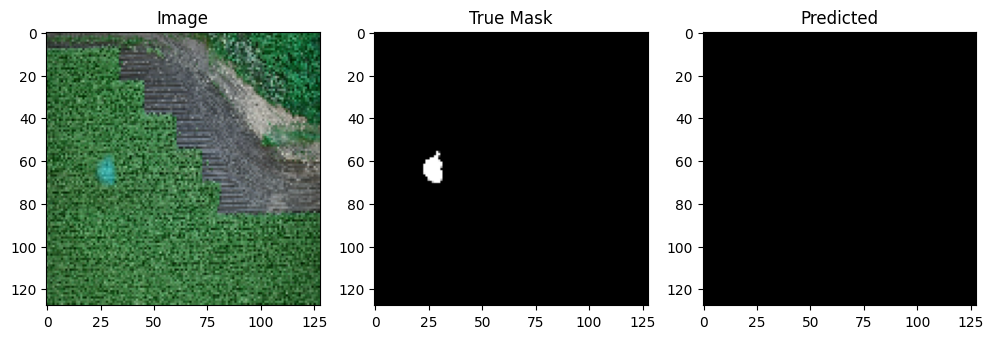

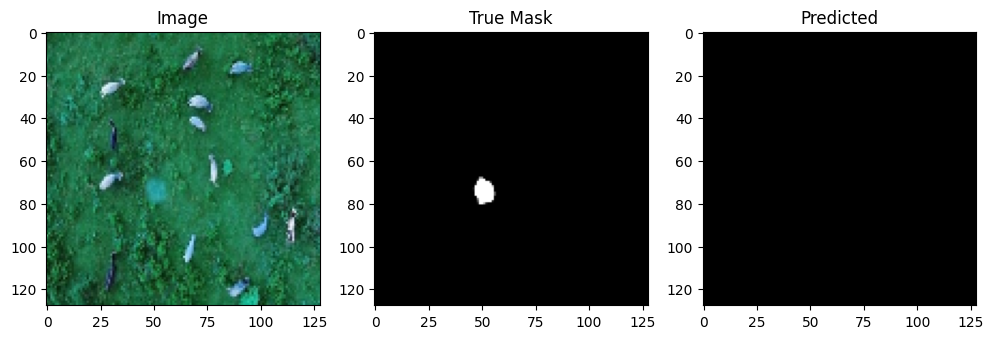

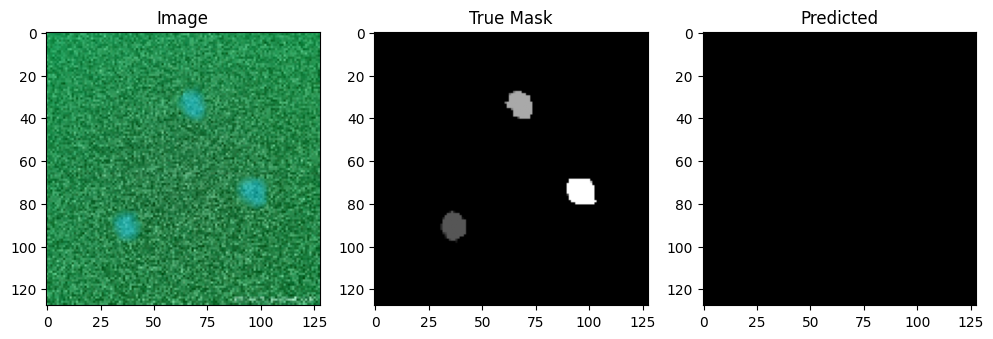

In [17]:
pred_masks = model.predict(X_test)
for i in range(3):   # Show 3 samples
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Image"); plt.imshow(X_test[i])
    plt.subplot(1,3,2); plt.title("True Mask"); plt.imshow(Y_test[i].squeeze(), cmap='gray')
    plt.subplot(1,3,3); plt.title("Predicted"); plt.imshow(pred_masks[i].squeeze()>0.5, cmap='gray')
    plt.show()


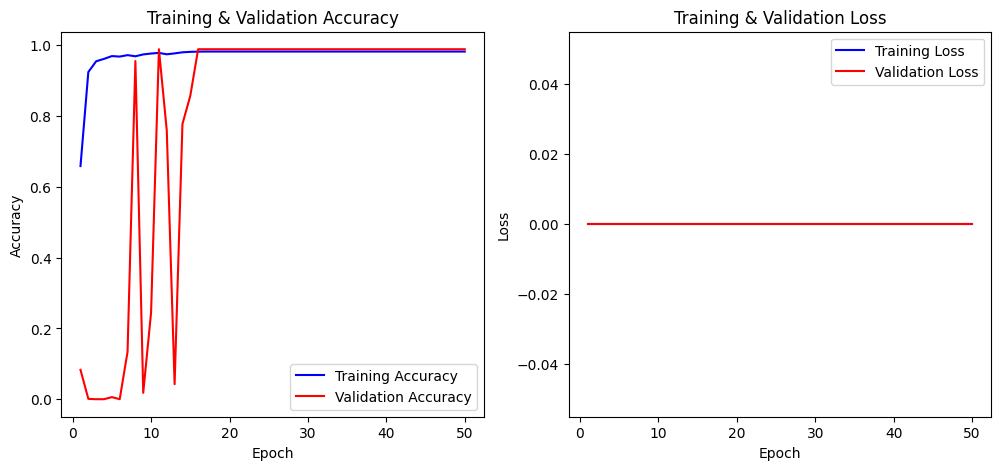

In [18]:
import matplotlib.pyplot as plt

# Training history stored in history.history (dictionary)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()